In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
## install command
#!pip install syft
import os
import pydicom
import copy
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import syft as sy

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import tools
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()

import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset
import imageio

from tqdm import tqdm
import time
from glob import glob
import os

In [2]:
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['siim-acr-pneumothorax-segmentation', 'siim-train-test']


In [3]:
# Show some images

train_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-test/*/*/*.dcm'))

print(len(train_fns))
print(len(test_fns))

10712
1377


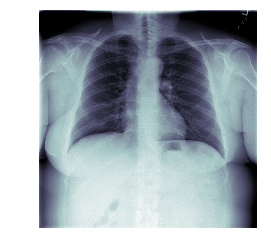

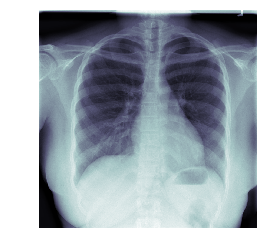

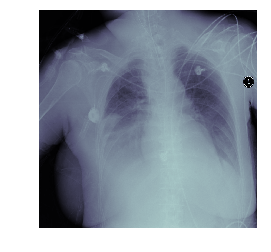

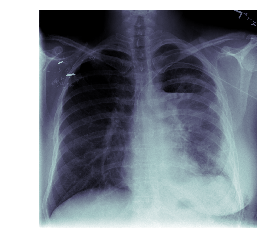

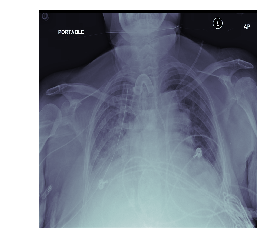

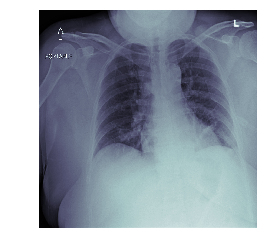

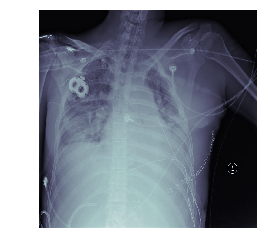

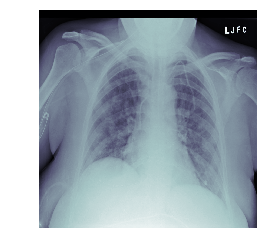

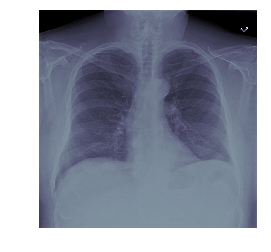

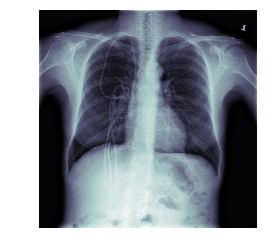

In [4]:
# show some images
from matplotlib import pyplot as plt
import pydicom

for k in range(10):
    fn = np.random.choice(test_fns)
    img = pydicom.read_file(fn).pixel_array
    plt.imshow(img, cmap='bone')
    plt.axis('off')
    plt.show()

In [5]:
# load rle-encoded masks
import pandas as pd
from collections import defaultdict
rles = pd.read_csv('../input/siim-train-test/siim/train-rle.csv')
# images can have multiple annotations
rles_ = defaultdict(list)
for image_id, rle in zip(rles['ImageId'], rles[' EncodedPixels']):
    rles_[image_id].append(rle)
rles = rles_
annotated = {k: v for k, v in rles.items() if v[0] != ' -1'}
print("%d of %d images are annotated" % (len(annotated), len(rles)))

2379 of 10675 images are annotated


In [6]:
print("Missing: ", len(train_fns) - len(rles))
# This was discussed here: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/96993#latest-560352

Missing:  37


In [7]:
# check the test images
means = []
from tqdm import tqdm_notebook as tqdm
for fn in tqdm(test_fns):
    img = pydicom.read_file(fn).pixel_array
    means.append(img.mean())
print("Test mean: ", np.mean(means))


Test mean:  124.68802690055809


In [8]:
# check the train images
means = []
for fn in tqdm(train_fns):
    img = pydicom.read_file(fn).pixel_array
    means.append(img.mean())
print("Train mean: ", np.mean(means))


Train mean:  125.08241941378667


In [9]:
# load rles
rles_df = pd.read_csv('../input/siim-train-test/siim/train-rle.csv')
# the second column has a space at the start, so manually giving column name
rles_df.columns = ['ImageId', 'EncodedPixels']

In [10]:
def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
    """Parse DICOM dataset and returns a dictonary with relevant fields.

    Args:
        dicom_data (dicom): chest x-ray data in dicom format.
        file_path (str): file path of the dicom data.
        rles_df (pandas.core.frame.DataFrame): Pandas dataframe of the RLE.
        encoded_pixels (bool): if True we will search for annotation.
        
    Returns:
        dict: contains metadata of relevant fields.
    """
    
    data = {}
    
    # Parse fields with meaningful information
    data['patient_name'] = dicom_data.PatientName
    data['patient_id'] = dicom_data.PatientID
    data['patient_age'] = int(dicom_data.PatientAge)
    data['patient_sex'] = dicom_data.PatientSex
    data['pixel_spacing'] = dicom_data.PixelSpacing
    data['file_path'] = file_path
    data['id'] = str(dicom_data.SOPInstanceUID)
    
    # look for annotation if enabled (train set)
    if encoded_pixels:
        encoded_pixels_list = rles_df[rles_df['ImageId']==dicom_data.SOPInstanceUID]['EncodedPixels'].values
       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        # get meaningful information (for train set)
        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return data

In [11]:
train_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-train/*/*/*.dcm'))
# parse train DICOM dataset
train_metadata_df = pd.DataFrame()
train_metadata_list = []
for file_path in tqdm(train_fns):
    dicom_data = pydicom.dcmread(file_path)
    train_metadata = dicom_to_dict(dicom_data, file_path, rles_df)
    train_metadata_list.append(train_metadata)
train_metadata_df = pd.DataFrame(train_metadata_list)

In [12]:
test_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-test/*/*/*.dcm'))
# parse test DICOM dataset
test_metadata_df = pd.DataFrame()
test_metadata_list = []
for file_path in tqdm(test_fns):
    dicom_data = pydicom.dcmread(file_path)
    test_metadata = dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=False)
    test_metadata_list.append(test_metadata)
test_metadata_df = pd.DataFrame(test_metadata_list)

In [13]:
missing_vals = train_metadata_df[train_metadata_df['encoded_pixels_count']==0]['encoded_pixels_count'].count()
print("Number of x-rays with missing labels: {}".format(missing_vals))

Number of x-rays with missing labels: 37


In [14]:
nok_count = train_metadata_df['has_pneumothorax'].sum()
ok_count = len(train_metadata_df) - nok_count
x = ['No Pneumothorax','Pneumothorax']
y = [ok_count, nok_count]
trace0 = Bar(x=x, y=y, name = 'Ok vs Not OK')
nok_encoded_pixels_count = train_metadata_df[train_metadata_df['has_pneumothorax']==1]['encoded_pixels_count'].values
trace1 = Histogram(x=nok_encoded_pixels_count, name='# of annotations')
fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=400, width=900, title='Pneumothorax Instances')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [15]:
pneumo_pat_age = train_metadata_df[train_metadata_df['has_pneumothorax']==1]['patient_age'].values
no_pneumo_pat_age = train_metadata_df[train_metadata_df['has_pneumothorax']==0]['patient_age'].values

In [16]:
pneumothorax = Histogram(x=pneumo_pat_age, name='has pneumothorax')
no_pneumothorax = Histogram(x=no_pneumo_pat_age, name='no pneumothorax')
fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(pneumothorax, 1, 1)
fig.append_trace(no_pneumothorax, 1, 2)
fig['layout'].update(height=400, width=900, title='Patient Age Histogram')
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [17]:
trace1 = Box(x=pneumo_pat_age, name='has pneumothorax')
trace2 = Box(x=no_pneumo_pat_age[no_pneumo_pat_age <= 120], name='no pneumothorax')
data = [trace1, trace2]
iplot(data)

In [18]:
def clean_data(df, mode):
    print('Tail before cleaning: ')
    print(df.tail())
    if mode == 'Train':
        labels_df = df.has_pneumothorax
        df = df.drop(columns=['file_path', 'has_pneumothorax', 'patient_id', 'patient_name'])
        
        df.encoded_pixels_list = df.encoded_pixels_list.astype(str)
        df.encoded_pixels_list = pd.get_dummies(df.encoded_pixels_list)
        df.encoded_pixels_list = df.encoded_pixels_list.astype(float)
        print('Encoded pixels list value counts after one-hot encoding: ')
        print(df.encoded_pixels_list.value_counts())
    else:
        labels_df = 0
        df = df.drop(columns=['file_path', 'patient_id', 'patient_name'])
    
    replace_map = {'patient_sex': {'M' : 0, 'F': 1}}
    df.replace(replace_map, inplace=True)
    print('Patient gender value counts: ')
    print(df.patient_sex.value_counts())
    
    df.id = df.id.str.replace('.', '')
    df.id = df.id.astype('float')
    
    df.pixel_spacing = df.pixel_spacing.astype(str)
    df.pixel_spacing = pd.get_dummies(df.pixel_spacing)
    df.pixel_spacing = df.pixel_spacing.astype(float)
    print('Encoded pixels spacing value counts after one-hot encoding: ')
    print(df.pixel_spacing.value_counts())
    
    print('Tail after cleaning: ')
    print(df.tail())
    return df, labels_df

In [19]:
train_df, train_labels_df = clean_data(train_metadata_df, 'Train')

Tail before cleaning: 
       encoded_pixels_count                     ...                                                   pixel_spacing
10707                     1                     ...                      [0.14300000000000002, 0.14300000000000002]
10708                     1                     ...                                                  [0.171, 0.171]
10709                     1                     ...                                                  [0.139, 0.139]
10710                     1                     ...                      [0.14300000000000002, 0.14300000000000002]
10711                     1                     ...                                                  [0.171, 0.171]

[5 rows x 10 columns]
Encoded pixels list value counts after one-hot encoding: 
1.0    8296
0.0    2416
Name: encoded_pixels_list, dtype: int64
Patient gender value counts: 
0    5903
1    4809
Name: patient_sex, dtype: int64
Encoded pixels spacing value counts after one-hot enco

In [20]:
test_df, test_labels_df = clean_data(test_metadata_df, 'Test')

Tail before cleaning: 
                                              file_path                     ...                                                   pixel_spacing
1372  ../input/siim-train-test/siim/dicom-images-tes...                     ...                                                  [0.168, 0.168]
1373  ../input/siim-train-test/siim/dicom-images-tes...                     ...                                                  [0.139, 0.139]
1374  ../input/siim-train-test/siim/dicom-images-tes...                     ...                                                  [0.168, 0.168]
1375  ../input/siim-train-test/siim/dicom-images-tes...                     ...                      [0.14300000000000002, 0.14300000000000002]
1376  ../input/siim-train-test/siim/dicom-images-tes...                     ...                                                  [0.168, 0.168]

[5 rows x 7 columns]
Patient gender value counts: 
0    747
1    630
Name: patient_sex, dtype: int64
Encoded pix

In [21]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 25
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 100
        self.workers = 2
        self.save_model = False

args = Arguments()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

train_on_gpu = torch.device("cuda" if use_cuda else "cpu")

In [22]:
hook = sy.TorchHook(torch)
client = sy.VirtualWorker(hook, id="client") 
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
crypto_provider = sy.VirtualWorker(hook, id="crypto_provider") 

In [23]:
#tensor = torch.tensor(train_metadata_df.values).federate((bob, alice))

#training_data = torch.utils.data.DataLoader(train_metadata_df.values)

base = sy.BaseDataset(torch.from_numpy(train_df.values),torch.from_numpy(train_labels_df.values))

base_federated=base.federate((bob, alice))

federated_train_loader = sy.FederatedDataLoader(base_federated,batch_size=args.batch_size)

print('Ferderated train loader was a success!')

Ferderated train loader was a success!


In [24]:
test = torch.from_numpy(test_df.values)

In [117]:
# modfied from https://github.com/OpenMined/PySyft/blob/dev/examples/tutorials/advanced/Federated%20CIFAR10.ipynb

# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1x64x4 
        self.conv1 = nn.Conv2d(1, 6, kernel_size=1, stride=1, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 9, kernel_size=1, stride=1, padding=2)
        self.conv3 = nn.Conv2d(9, 12, kernel_size=1, stride=1, padding=1)
        self.fc1 = nn.Linear(64*6, 100)
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        print(x.shape)
        x = x.float()
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*6)
        #6*64
    # x = x.view(x.size(0), 6*64*1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [118]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        target = target.view(args.batch_size)
        data.unsqueeze_(0)
        output = model(data.unsqueeze(0))
        loss = F.nll_loss(output, target.long())
        loss.backward()
        optimizer.step()
        model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(train_loader) * args.batch_size, #batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [119]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [120]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) #<--TODO momentum is not supported at the moment

print(model)

#<--Train Neural network and validate with test set after completion of training every epoch
for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 9, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(9, 12, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=384, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
torch.Size([1, 1, 64, 6])


RuntimeError: shape '[-1, 384]' is invalid for input of size 360